In [1]:
import json
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pymutspec.annotation import rev_comp
from pymutspec.constants import possible_sbs192, possible_codons
from pymutspec.draw import plot_mutspec192
import SigProfilerAssignment
from scipy.stats import spearmanr

from utils import sbs2effect, collapse_sbs192, complete_sbs_columns

sns.set_style()
%matplotlib inline

In [2]:
# version of SigProfilerAssignment
SigProfilerAssignment.__version__

'0.1.6'

In [3]:
# funcs for specific data processing and writing


def read_human_triplet_counts(include_lower_nucls=False):
    with open("./data/triplet_counts_GRCh37.json") as fin:
        _human_counts_raw = json.load(fin)
        if include_lower_nucls:
            human_counts = defaultdict(int)
            for triplet, n in _human_counts_raw.items():
                human_counts[triplet.upper()] += n
            human_counts = dict(human_counts)        
        else:
            # without aAa, tAA, tgc etc. Only upper case
            _human_counts_raw = {x: _human_counts_raw[x] for x in possible_codons}
            human_counts = defaultdict(int)
            for triplet, n in _human_counts_raw.items():
                human_counts[triplet.upper()] += n
            human_counts = dict(human_counts)
        return human_counts


def save_wide_cls_spectra(df: pd.DataFrame, filename=None, human_counts: dict={}, scale_coef=6.6e-5):
    assert df.shape[1] == 96
    df.columns.name = "MutationType"
    multiplier = df.columns.to_series().apply(lambda x: x[0] + x[2] + x[-1]).map(human_counts)
    rescaled = (df * multiplier * scale_coef).T
    rescaled = rescaled.round().astype(int)
    if filename is not None:
        rescaled.sort_index().to_csv(filename, sep="\t")
    return rescaled

In [4]:
possible_sbs6 = ["C>A", "C>G", "C>T", "T>A", "T>C", "T>G"]
possible_sbs96 = [x for x in possible_sbs192 if x[2:5] in possible_sbs6]
print(possible_sbs96)

['A[C>A]A', 'A[C>A]C', 'A[C>A]G', 'A[C>A]T', 'C[C>A]A', 'C[C>A]C', 'C[C>A]G', 'C[C>A]T', 'G[C>A]A', 'G[C>A]C', 'G[C>A]G', 'G[C>A]T', 'T[C>A]A', 'T[C>A]C', 'T[C>A]G', 'T[C>A]T', 'A[C>G]A', 'A[C>G]C', 'A[C>G]G', 'A[C>G]T', 'C[C>G]A', 'C[C>G]C', 'C[C>G]G', 'C[C>G]T', 'G[C>G]A', 'G[C>G]C', 'G[C>G]G', 'G[C>G]T', 'T[C>G]A', 'T[C>G]C', 'T[C>G]G', 'T[C>G]T', 'A[C>T]A', 'A[C>T]C', 'A[C>T]G', 'A[C>T]T', 'C[C>T]A', 'C[C>T]C', 'C[C>T]G', 'C[C>T]T', 'G[C>T]A', 'G[C>T]C', 'G[C>T]G', 'G[C>T]T', 'T[C>T]A', 'T[C>T]C', 'T[C>T]G', 'T[C>T]T', 'A[T>A]A', 'A[T>A]C', 'A[T>A]G', 'A[T>A]T', 'C[T>A]A', 'C[T>A]C', 'C[T>A]G', 'C[T>A]T', 'G[T>A]A', 'G[T>A]C', 'G[T>A]G', 'G[T>A]T', 'T[T>A]A', 'T[T>A]C', 'T[T>A]G', 'T[T>A]T', 'A[T>C]A', 'A[T>C]C', 'A[T>C]G', 'A[T>C]T', 'C[T>C]A', 'C[T>C]C', 'C[T>C]G', 'C[T>C]T', 'G[T>C]A', 'G[T>C]C', 'G[T>C]G', 'G[T>C]T', 'T[T>C]A', 'T[T>C]C', 'T[T>C]G', 'T[T>C]T', 'A[T>G]A', 'A[T>G]C', 'A[T>G]G', 'A[T>G]T', 'C[T>G]A', 'C[T>G]C', 'C[T>G]G', 'C[T>G]T', 'G[T>G]A', 'G[T>G]C', 'G[T>G]G'

## Load and Explore human trinucl counts for renormalization (emulation of human spectra for COSMIC decomposition) 

In [5]:
# read human genome trinucleotide counts
human_counts = read_human_triplet_counts()
human_counts_wl = read_human_triplet_counts(True)

In [6]:
x = pd.Series(human_counts).sort_index().values
y = pd.Series(human_counts_wl).sort_index().values
print(spearmanr(x, y))
# plt.scatter(x, y)
# plt.show()

SignificanceResult(statistic=0.9725274725274725, pvalue=5.851608347350969e-41)


In [7]:
# check forvard and rev-comp triplets freqs
d = defaultdict(dict)
for triplet, n in human_counts_wl.items():
    if triplet[1] in "CT":
        # print(triplet, n)
        d[triplet]["cosmic"] = n
    else:
        d[rev_comp(triplet)]["other"] = n

d = pd.DataFrame(d).T
d["diff"] = d.cosmic - d.other
d["diff%"] = d["diff"] / d['cosmic']
d

,other,cosmic,diff,diff%
TTA,61780796,61863454,82658,0.001336
GTT,43438625,43597716,159091,0.003649
ACC,34933366,34902100,-31266,-0.000896
CCC,39705055,39661785,-43270,-0.001091
CCT,53346173,53384677,38504,0.000721
CTA,38490211,38440347,-49864,-0.001297
CCA,55455476,55332829,-122647,-0.002217
TTG,56465883,56667346,201463,0.003555
TTT,114318196,114683164,364968,0.003182
GTA,33829362,33842736,13374,0.000395


Forvard and rev-comp triplets freqs are almost equal, so we need to use triplets with C & T in 2nd position

## Need to generate many variants of 96-comp spectra:

- **low ts**: only transitions (Gh>Ah and Th>Ch)
- **low ts&tv**: transitions (Gh>Ah and Th>Ch) & averaged transversions [(h + l) / 2]
- **high ts**: only transitions (Ch>Th and Ah>Gh)
- **high ts&tv**: transitions (Ch>Th and Ah>Gh) & averaged transversions [(h + l) / 2]

- **diff**: **high ts** - **low ts**
- **diff&tv**: **high ts&tv** - **low ts&tv**

In [8]:
# Load and prepare spectra data
species_spectra = pd.read_csv('../1data_derivation/dataset/MutSpecVertebrates192.csv.gz')
species_spectra = species_spectra[species_spectra.Gene == 'Cytb']
species_spectra['Mut'] = species_spectra['Mut'].apply(rev_comp) # to H-strand notation

print(species_spectra.Species.nunique(), 'species')
species_spectra.head()

1697 species


,Gene,Class,Species,Mut,Observed,Expected,MutSpec
39552,Cytb,Mammalia,Tarsius_dentatus,T[T>G]T,NaN,0.00,0.0
39553,Cytb,Mammalia,Tarsius_dentatus,G[T>G]T,NaN,0.00,0.0
39554,Cytb,Mammalia,Tarsius_dentatus,C[T>G]T,NaN,0.00,0.0
39555,Cytb,Mammalia,Tarsius_dentatus,A[T>G]T,NaN,0.00,0.0
39556,Cytb,Mammalia,Tarsius_dentatus,T[T>G]G,NaN,11.95,0.0


In [9]:
# check most popular sbs - we see C>T, therefore we are using H-strand 
species_spectra.groupby('Mut').MutSpec.mean().sort_values()

Mut
C[T>G]T    0.000000
A[T>A]T    0.000000
A[T>G]T    0.000000
C[A>C]T    0.000000
C[A>T]T    0.000000
             ...   
A[C>T]T    0.028516
A[C>T]A    0.029996
G[C>T]C    0.031454
A[C>T]C    0.039361
C[C>T]C    0.043280
Name: MutSpec, Length: 192, dtype: float64

In [10]:
species_spectra_wide = complete_sbs_columns(
    species_spectra.groupby(["Class", "Species", "Mut"]).MutSpec.sum().unstack(), 192)
cls_spectra_wide = species_spectra_wide.mean(level=0)
cls_spectra_wide.head()

Mut,A[A>C]A,A[A>C]C,A[A>C]G,A[A>C]T,C[A>C]A,C[A>C]C,C[A>C]G,C[A>C]T,G[A>C]A,G[A>C]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Class,,,,,,,,,,,,,,,,,,,,,
Actinopteri,0.000066,0.001479,0.000500,0.0,0.000865,0.002439,0.000998,0.0,0.000387,0.000729,...,0.001011,0.0,0.001081,0.001138,0.002074,0.0,0.000458,0.000397,0.000828,0.0
Amphibia,0.000000,0.000273,0.000506,0.0,0.001441,0.004229,0.001683,0.0,0.000102,0.000000,...,0.000734,0.0,0.000593,0.000470,0.001442,0.0,0.000355,0.000000,0.001295,0.0
Aves,0.000000,0.000000,0.000051,0.0,0.000048,0.000000,0.000088,0.0,0.000000,0.001011,...,0.000374,0.0,0.000633,0.001844,0.001183,0.0,0.000364,0.000000,0.000183,0.0
Lepidosauria,0.000023,0.001169,0.000357,0.0,0.001099,0.002600,0.001345,0.0,0.000801,0.000801,...,0.000593,0.0,0.000765,0.000169,0.001713,0.0,0.000393,0.000233,0.000728,0.0
Mammalia,0.000000,0.000783,0.000064,0.0,0.001615,0.001756,0.000464,0.0,0.000140,0.000724,...,0.000524,0.0,0.000615,0.000608,0.000894,0.0,0.000375,0.000394,0.000538,0.0


### Get spectra that contain only transitions (**Only Ts's**)

In [11]:
# get spectra with "low Ts" (minor transitions in the complementar pairs) only
sbs_low_ts = ["G>A", "T>C"]
low_ts_only = collapse_sbs192(complete_sbs_columns(
    cls_spectra_wide[[x for x in possible_sbs192 if x[2:5] in sbs_low_ts]], 192), 96)
low_ts_only

Mut,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Class,,,,,,,,,,,,,,,,,,,,,
Actinopteri,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Amphibia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aves,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Lepidosauria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mammalia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# same with "high Ts" (major transitions in the complementar pairs)
sbs_high_ts = ["C>T", "A>G"]
high_ts_only = collapse_sbs192(complete_sbs_columns(
    cls_spectra_wide[[x for x in possible_sbs192 if x[2:5] in sbs_high_ts]], 192), 96)
high_ts_only

Mut,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Class,,,,,,,,,,,,,,,,,,,,,
Actinopteri,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Amphibia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aves,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Lepidosauria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mammalia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# substract "low Ts" from "high Ts" to get "diff"
diff_ts_only = high_ts_only - low_ts_only
diff_ts_only[diff_ts_only < 0] = 0

### Get spectra that contain transitions and transversions (**Ts&Tv**)

In [14]:
# average number of transversions in each complementary pair
sbs_tv = ['A>C', 'A>T', 'C>A', 'C>G', 'G>C', 'G>T', 'T>A', 'T>G']
tv_only = collapse_sbs192(complete_sbs_columns(
    cls_spectra_wide[[x for x in possible_sbs192 if x[2:5] in sbs_tv]], 192), 96) / 2
tv_only

Mut,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Class,,,,,,,,,,,,,,,,,,,,,
Actinopteri,0.000065,0.000459,0.000252,0.0,0.001387,0.000966,0.000736,0.000556,0.001555,0.000571,...,0.001004,0.000250,0.001659,0.000933,0.002256,0.000740,0.000406,0.000392,0.000847,0.000033
Amphibia,0.000000,0.000113,0.000000,0.0,0.001436,0.003285,0.001856,0.001142,0.000308,0.000556,...,0.001209,0.000253,0.000562,0.000235,0.002835,0.000136,0.000177,0.000051,0.001368,0.000000
Aves,0.000000,0.000000,0.000000,0.0,0.000866,0.000649,0.001015,0.000775,0.000272,0.000231,...,0.000231,0.000026,0.000456,0.001427,0.000591,0.000000,0.000738,0.000000,0.000115,0.000000
Lepidosauria,0.000008,0.001191,0.000077,0.0,0.003666,0.001244,0.002003,0.001190,0.001344,0.001543,...,0.000969,0.000178,0.000952,0.000485,0.002156,0.000584,0.000275,0.000517,0.000914,0.000011
Mammalia,0.000172,0.000525,0.000140,0.0,0.001253,0.001098,0.002255,0.000736,0.000743,0.001166,...,0.000494,0.000032,0.000575,0.000666,0.001325,0.000391,0.000280,0.000267,0.001076,0.000000


In [15]:
low_ts_with_tv  = tv_only + low_ts_only
high_ts_with_tv = tv_only + high_ts_only
diff_ts_with_tv = tv_only + diff_ts_only

low_ts_with_tv

Mut,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Class,,,,,,,,,,,,,,,,,,,,,
Actinopteri,0.000065,0.000459,0.000252,0.0,0.001387,0.000966,0.000736,0.000556,0.001555,0.000571,...,0.001004,0.000250,0.001659,0.000933,0.002256,0.000740,0.000406,0.000392,0.000847,0.000033
Amphibia,0.000000,0.000113,0.000000,0.0,0.001436,0.003285,0.001856,0.001142,0.000308,0.000556,...,0.001209,0.000253,0.000562,0.000235,0.002835,0.000136,0.000177,0.000051,0.001368,0.000000
Aves,0.000000,0.000000,0.000000,0.0,0.000866,0.000649,0.001015,0.000775,0.000272,0.000231,...,0.000231,0.000026,0.000456,0.001427,0.000591,0.000000,0.000738,0.000000,0.000115,0.000000
Lepidosauria,0.000008,0.001191,0.000077,0.0,0.003666,0.001244,0.002003,0.001190,0.001344,0.001543,...,0.000969,0.000178,0.000952,0.000485,0.002156,0.000584,0.000275,0.000517,0.000914,0.000011
Mammalia,0.000172,0.000525,0.000140,0.0,0.001253,0.001098,0.002255,0.000736,0.000743,0.001166,...,0.000494,0.000032,0.000575,0.000666,0.001325,0.000391,0.000280,0.000267,0.001076,0.000000


In [16]:
# Concatenate all 6 variants pairwisely and save to input directory

SAMPLE_OUTDIR = './data/SigProfilerAssignment/input/'

# we can use any subsample of human genome to calculate trinucl freqs and we will give 
# same results due to too big counts of trinucleotides (data not shown but precicely checked)
include_lower_nucls = False
THR = 0.000044 if include_lower_nucls else 0.000066
human_counts = read_human_triplet_counts(include_lower_nucls)

d = []
for x, _lbl in zip([low_ts_only, low_ts_with_tv], ["Ts only", "Ts & Tv"]):
    x = x.copy()
    x.index = [y + f"__{_lbl}" for y in x.index]
    d.append(x)
    
total_samples = pd.concat(d)
save_wide_cls_spectra( 
    total_samples, SAMPLE_OUTDIR+"low_Ts_samples.txt", human_counts, THR,
)


d = []
for x, _lbl in zip([high_ts_only, high_ts_with_tv], ["Ts only", "Ts & Tv"]):
    x = x.copy()
    x.index = [y + f"__{_lbl}" for y in x.index]
    d.append(x)
    
total_samples = pd.concat(d)
save_wide_cls_spectra( 
    total_samples, SAMPLE_OUTDIR+"high_Ts_samples.txt", human_counts, THR,
)


d = []
for x, _lbl in zip([diff_ts_only, diff_ts_with_tv], ["Ts only", "Ts & Tv"]):
    x = x.copy()
    x.index = [y + f"__{_lbl}" for y in x.index]
    d.append(x)
    
total_samples = pd.concat(d)
save_wide_cls_spectra( 
    total_samples, SAMPLE_OUTDIR+"high_minus_low_Ts_samples.txt", human_counts, THR,
)

,Actinopteri__Ts only,Amphibia__Ts only,Aves__Ts only,Lepidosauria__Ts only,Mammalia__Ts only,Actinopteri__Ts & Tv,Amphibia__Ts & Tv,Aves__Ts & Tv,Lepidosauria__Ts & Tv,Mammalia__Ts & Tv
MutationType,,,,,,,,,,
A[C>A]A,0,0,0,0,0,0,0,0,0,0
A[C>A]C,0,0,0,0,0,1,0,0,2,1
A[C>A]G,0,0,0,0,0,0,0,0,0,0
A[C>A]T,0,0,0,0,0,0,0,0,0,0
C[C>A]A,0,0,0,0,0,3,3,2,8,3
...,...,...,...,...,...,...,...,...,...,...
G[T>G]T,0,0,0,0,0,1,0,0,1,1
T[T>G]A,0,0,0,0,0,1,0,2,1,1
T[T>G]C,0,0,0,0,0,1,0,0,1,1


### Check input spectra
These spectra renormalized, e.g. we can imagine we translated observed mutagenesis from vertebrates classes to human genome

So, currently we can run signatures assignemnt on COSMIC

In [17]:
low = pd.read_csv('./data/SigProfilerAssignment/input/low_Ts_samples.txt', sep='\t', index_col=0)
high = pd.read_csv('./data/SigProfilerAssignment/input/high_Ts_samples.txt', sep='\t', index_col=0)
hml = pd.read_csv('./data/SigProfilerAssignment/input/high_minus_low_Ts_samples.txt', sep='\t', index_col=0)

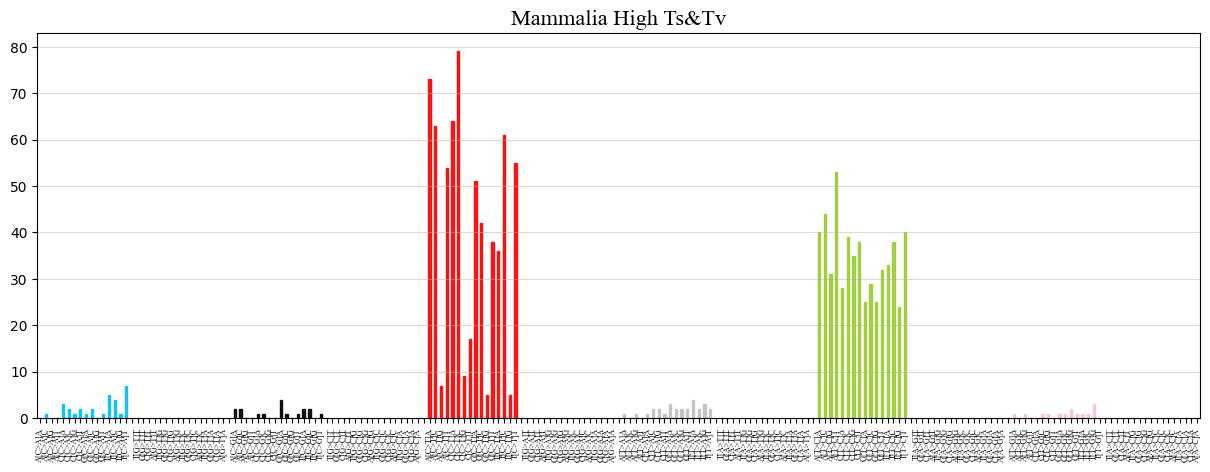

In [19]:
x = high['Mammalia__Ts & Tv'].rename('MutSpec')
x.index.name = 'Mut'
x = x.reset_index()
plot_mutspec192(x, title='Mammalia High Ts&Tv', figsize=(15, 5));

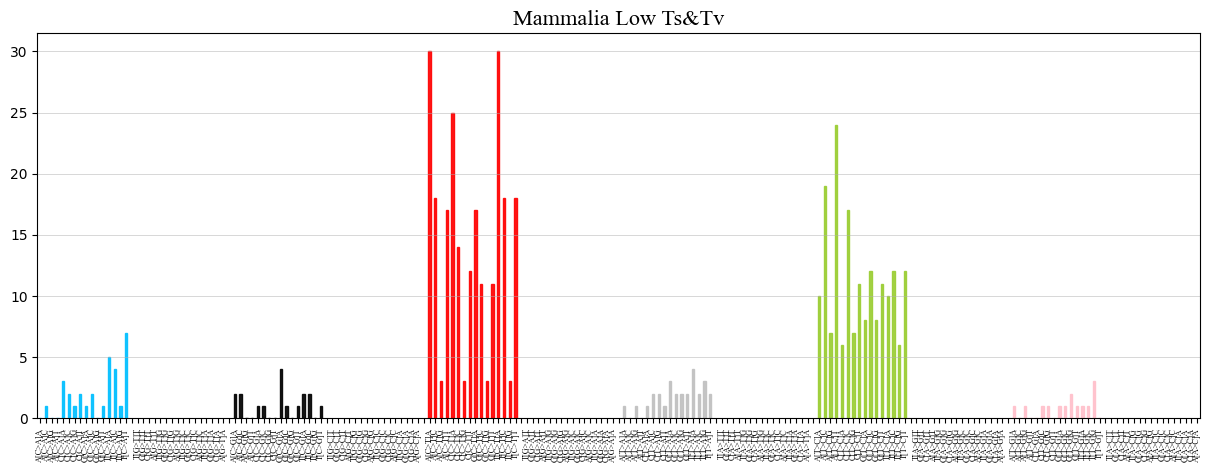

In [20]:
x = low['Mammalia__Ts & Tv'].rename('MutSpec')
x.index.name = 'Mut'
x = x.reset_index()
plot_mutspec192(x, title='Mammalia Low Ts&Tv', figsize=(15, 5));

## Run SigProfilerAssignment

In [65]:
# Run sigprofiller cosmic_fit func to decompose chordates classes spcectra to COSMIC signatures
# Run on several different spectra types (Low, High, Diff) separately

from SigProfilerAssignment import Analyzer as Analyze

samples_pattern = "./data/SigProfilerAssignment/input/{}_samples.txt"
OUTDIR = "./data/SigProfilerAssignment/output/"
output_pattern = OUTDIR + "{}/"

exclude_signature_subgroups = [
    'Artifact_signatures',
    'Immunosuppressants_signatures',
    'Treatment_signatures',
    'Lymphoid_signatures',
    'Colibactin_signatures',
    'AA_signatures',
]

for label in ["low_Ts", "high_Ts", "high_minus_low_Ts"]:
    samples = samples_pattern.format(label)
    output  = output_pattern.format(label)
    Analyze.cosmic_fit(samples, output, input_type="matrix", context_type="96",
                    cosmic_version=3.3, exome=False,
                    nnls_remove_penalty=0.01, nnls_add_penalty = 0.02,
                    exclude_signature_subgroups=exclude_signature_subgroups, 
                    export_probabilities=False, make_plots=True,
                    sample_reconstruction_plots=False, verbose=False)

The following signatures are excluded: SBS32 SBS11 SBS25 SBS31 SBS32 SBS35 SBS86 SBS87 SBS90 SBS99 SBS22 SBS22a SBS22b SBS88 SBS27 SBS43 SBS45 SBS46 SBS47 SBS48 SBS49 SBS50 SBS51 SBS52 SBS53 SBS54 SBS55 SBS56 SBS57 SBS58 SBS59 SBS60 SBS95 SBS9 SBS84 SBS85
Assigning COSMIC sigs or Signature Database ...... 


|████████████████████████████████████████| 10/10 [100%] in 0.7s (14.94/s) 


 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 
The following signatures are excluded: SBS32 SBS11 SBS25 SBS31 SBS32 SBS35 SBS86 SBS87 SBS90 SBS99 SBS22 SBS22a SBS22b SBS88 SBS27 SBS43 SBS45 SBS46 SBS47 SBS48 SBS49 SBS50 SBS51 SBS52 SBS53 SBS54 SBS55 SBS56 SBS57 SBS58 SBS59 SBS60 SBS95 SBS9 SBS84 SBS85
Assigning COSMIC sigs or Signature Database ...... 
|████████████████████████████████████████| 10/10 [100%] in 0.7s (13.49/s) 


 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 
The following signatures are excluded: SBS32 SBS11 SBS25 SBS31 SBS32 SBS35 SBS86 SBS87 SBS90 SBS99 SBS22 SBS22a SBS22b SBS88 SBS27 SBS43 SBS45 SBS46 SBS47 SBS48 SBS49 SBS50 SBS51 SBS52 SBS53 SBS54 SBS55 SBS56 SBS57 SBS58 SBS59 SBS60 SBS95 SBS9 SBS84 SBS85
Assigning COSMIC sigs or Signature Database ...... 
|████████████████████████████████████████| 10/10 [100%] in 0.7s 

In [66]:
# make Solution_Stats with assignment quality
d = pd.concat([pd.read_csv(f"{OUTDIR}/{label}/"
        "Assignment_Solution/Solution_Stats/Assignment_Solution_Samples_Stats.txt", sep='\t')\
            .assign(Run=label).set_index(['Run', 'Sample Names']) \
            for label in ["low_Ts", "high_Ts", "high_minus_low_Ts"]])

d.to_csv(f'{OUTDIR}/Solution_Stats.txt', sep='\t')
d.head()

Total Mutations  Cosine Similarity  L1 Norm  \
Run    Sample Names                                                         
low_Ts Actinopteri__Ts only               496              0.938  202.460   
       Amphibia__Ts only                  507              0.916  233.596   
       Aves__Ts only                      335              0.948  123.255   
       Lepidosauria__Ts only              383              0.813  245.587   
       Mammalia__Ts only                  413              0.923  191.257   

                             L1_Norm_%  L2 Norm L2_Norm_%  KL Divergence  \
Run    Sample Names                                                        
low_Ts Actinopteri__Ts only    40.819%   34.667   34.955%        0.17688   
       Amphibia__Ts only       46.074%   43.321   40.611%        0.22380   
       Aves__Ts only           36.793%   20.655   32.183%        0.16529   
       Lepidosauria__Ts only   64.122%   50.443   58.979%        0.37607   
       Mammalia__Ts only       46.309%   32.364   38.707%        0.21573   

                              Correlation  
Run    Sample Names                        
low_Ts Actinopteri__Ts only         0.915  
       Amphibia__Ts only            0.889  
       Aves__Ts only                0.928  
       Lepidosauria__Ts only        0.762  
       Mammalia__Ts only            0.896

## Plot beautiful images and add them to single panel
see modified scpipt [plotActivity.py](./plotActivity.py) from sigProfilerPlotting lib

In [67]:
import pandas as pd

# merge tables to 'total' one
data = []
index_odr = [
 'Actinopteri__Ts only',
 'Amphibia__Ts only',
 'Aves__Ts only',
 'Lepidosauria__Ts only',
 'Mammalia__Ts only',
 'Actinopteri__Ts & Tv',
 'Amphibia__Ts & Tv',
 'Aves__Ts & Tv',
 'Lepidosauria__Ts & Tv',
 'Mammalia__Ts & Tv',
 ]

for label in ["high_Ts", "low_Ts", "high_minus_low_Ts"]:
    d = pd.read_csv(f'{OUTDIR}/{label}/'
                'Assignment_Solution/Activities/Assignment_Solution_Activities.txt', 
                sep='\t', index_col=0).loc[index_odr]
    
    if label == 'low_Ts':
        label = 'low-'
    elif label == 'high_Ts':
        label = 'high-'
    elif label == 'high_minus_low_Ts':
        label = 'diff-'
    
    d.index = label + d.index.str.replace(' only', '')
    data.append(d)

df_full = pd.concat(data)
df_ts_only = df_full.loc[~df_full.index.str.contains('Tv')]
df_ts_only.index = df_ts_only.index.str.replace('__Ts', '')


path_to_total_acivities = f'{OUTDIR}/Assignment_Solution_Activities.txt'
df_full.to_csv(path_to_total_acivities, sep='\t')
df_ts_only.to_csv(path_to_total_acivities.replace('.txt', '_Ts.txt'), sep='\t')
df_full.head()

,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,SBS7b,SBS7c,SBS7d,...,SBS39,SBS40,SBS41,SBS42,SBS44,SBS89,SBS91,SBS92,SBS93,SBS94
Samples,,,,,,,,,,,,,,,,,,,,,
high-Actinopteri__Ts,3,0,0,0,208,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
high-Amphibia__Ts,0,57,0,0,102,0,0,0,0,0,...,0,0,0,0,193,0,0,0,0,0
high-Aves__Ts,0,0,0,0,342,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
high-Lepidosauria__Ts,3,0,0,0,203,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
high-Mammalia__Ts,0,0,0,0,189,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
# total
from plotActivity import plotActivity

outpath = f"{OUTDIR}/total.pdf"

plotActivity(
    path_to_total_acivities, outpath, 
    bin_size=30, 
    # custom_colors=custom_colors,
    delimiter_step=6, delimiter_size=2,
    # rename=True,
)

['#acf2d0', '#63d69e', '#f8b6b3', '#fcde97', '#fad682', 'tab:pink', 'tab:orange', 'tab:purple', 'tab:olive']


In [69]:
# only Ts
outpath = f"{OUTDIR}/only_Ts.pdf"

plotActivity(
    path_to_total_acivities.replace('.txt', '_Ts.txt'), 
    outpath, 
    bin_size=50,
    delimiter_step=3, delimiter_size=2,
    rename=True, figure_width=4,
)

Colors replaced
['#acf2d0', '#63d69e', '#f8b6b3', '#fcde97', '#fad682', 'tab:pink', 'tab:olive', 'tab:orange', 'tab:purple']
